<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages

import string
import numpy as np
import re
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, GRU, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import nltk
from nltk.corpus import stopwords
%matplotlib inline


## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [2]:
## Open and read file

base_dir='/Users/dominiclee/Library/CloudStorage/OneDrive-NgeeAnnPolytechnic/Polytechnic/Year 2 Semester 1/DL/Asg 2/Problem 1'
filename = "snapchat_reviews.csv"
path_to_file = os.path.join(base_dir, filename)
df = pd.read_csv(filename)
print(df.shape)
print(df.info())


(40000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              40000 non-null  object 
 1   userName              40000 non-null  object 
 2   userImage             40000 non-null  object 
 3   content               40000 non-null  object 
 4   score                 40000 non-null  int64  
 5   thumbsUpCount         40000 non-null  int64  
 6   reviewCreatedVersion  25026 non-null  object 
 7   at                    40000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
dtypes: float64(2), int64(2), object(6)
memory usage: 3.1+ MB
None


In [3]:
# Ensuring each value has 8000 reviews
# Balanced dataset ensures machine learns fairly and will not be biased to any values

df['score'].value_counts()

1    8000
2    8000
3    8000
4    8000
5    8000
Name: score, dtype: int64

In [4]:
## Converting emojis & removing emoticons

# Step 1: Replace emoji with relevant word it represents
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace("_","").replace(":"," ").replace(",","").split("_")))
    return text

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

In [5]:
# Converting df reviews to list and applying the functions

# Removing emoticons because they are uncommon and could confuse the machine (low sample size)
# Converting emojis because they are common and will help with the context and prediction of the review

reviews_list = df['content'].tolist()
reviews_list_c = []
for review in reviews_list:
    processing = convert_emojis(review)
    final = remove_emoticons(processing)
    reviews_list_c.append(final)


In [6]:
# Testing if the functions are working as intended

test_emoji = "wow😀hi"
test_emoji = convert_emojis(test_emoji)

test_emoticon = "This is a :^)hi"
test_emoticon = remove_emoticons(test_emoticon)

print(test_emoji)
print(test_emoticon)

wow grinningface hi
This is a hi


In [8]:
# Ensuring reviews_list_c is in the correct shape and ensuring that all emojis are converted

print(len(reviews_list_c))
for review in reviews_list_c:
    print(review)

40000
Best apps
Lag
Adnan
I have install the snapchat .After a few days snapchat se 1 message aaya jisame ye likha tha ki unfortunatly snapchat has stopped .Why??????
Pic qwality very low
Good camera
Snapchat keeps banning me for no reason literally no damn reason I would wake up in the morning and have to make a new account bc snapchat wanted to keep harassing me by permanently banning my accounts when I have done absolutely nothing to get banned for I'm tired of this
ਖਦਗੲਬਕ
Why is snapchat being so partial towards iPhone users? Why don't the android users get to use functions like bounce or boomerang on their snap? Going to STOP using snapchat if Android doesn't get the bounce feature right now!!!
More Clutter get rid of quick add
@y@/y GBkßd_DeSoto
Okay
I have it set to not have access to my contacts (no contact permissions on android. Yet Snapchat ignores this and goes and recommends I add people who are only in WhatsApp on my phone (which it would have no other way of finding.
Bad

In [9]:
# Replace old column content with reviews_list_c content
print(df.columns[3])

# We see that content col is at index 3

reviews_list_c_pd = pd.DataFrame(reviews_list_c)

df['content'] = reviews_list_c_pd

content


In [10]:
## After converting all emojis to text
## We will remove all text that are not using the alphabets
## Regarding languages that are not english but use the alphabets we will leave them as it 
## is very hard to differentiate what is and what is not and english word

def isEnglish(s):
  check = s.isascii()
  if check:
    lang = "en"
  else:
    lang = "nan"
  return lang

df['lang'] = df['content'].apply(isEnglish)

In [11]:
print(df['lang'].value_counts())

en     37929
nan     2071
Name: lang, dtype: int64


In [12]:
df.drop(df.index[df['lang'] == "nan"], inplace=True)
df.shape

(37929, 11)

In [13]:
# Next: Check and Remove reviews with no content

checker = []
for i  in range(len(reviews_list_c)):
    if reviews_list_c[i] == '':
        checker.append(i)
print(checker)

# Here we see that reviews index 11823 and 24805 need to be removed.
# Removing these reviews

print(df['content'][11823] == "")
print(df['content'][24805] == "")

df = df.drop(11823)
df = df.drop(24805)

df = df.reset_index(drop=True)

[11823, 24805]
True
True


In [14]:
# Checking to ensure those rows have been deleted

print(df.shape)
test = df['content'].tolist()
checker = []
for i in range(len(test)):
    if test[i] == "":
        checker.append(i)
print(checker)

(37927, 11)
[]


In [15]:
# Cleaning the text. Lowercasing all words and taking away tags

def clean_text(text):
    
    text=re.sub("</?.*?>"," <> ",text)
    
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    return text

df['content_clean'] = df['content'].apply(lambda x:clean_text(x))

In [16]:
df['content_clean']

0                                                best apps
1                                                      lag
2                                                    adnan
3        i have install the snapchat after a few days s...
4                                     pic qwality very low
                               ...                        
37922                                           muzmlekana
37923                                                   ok
37924                                  it is very nice app
37925                                               superb
37926               very nice app its really good i rate 5
Name: content_clean, Length: 37927, dtype: object

In [17]:
## Tokenize text. Allows us to remove stopwords and lemmatize text
## This allows model to learn more efficiently

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df['content_tokenized'] = df['content_clean'].apply(lambda x: tokenize(x))
df['content_tokenized']

0                                             [best, apps]
1                                                    [lag]
2                                                  [adnan]
3        [i, have, install, the, snapchat, after, a, fe...
4                                [pic, qwality, very, low]
                               ...                        
37922                                         [muzmlekana]
37923                                                 [ok]
37924                            [it, is, very, nice, app]
37925                                             [superb]
37926     [very, nice, app, its, really, good, i, rate, 5]
Name: content_tokenized, Length: 37927, dtype: object

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dominic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Removing stopwords. These words play no role in determining the sentiment of the review. E.g. "it", "has"

def remove_stopwords(text):
    for word in text:
        if word in stopwords.words('english'):
            text.remove(word)
    return text

df['content_no_stopwords'] = df['content_tokenized'].apply(lambda x:remove_stopwords(x))
df['content_no_stopwords']

0                                             [best, apps]
1                                                    [lag]
2                                                  [adnan]
3        [have, install, snapchat, a, days, snapchat, s...
4                                      [pic, qwality, low]
                               ...                        
37922                                         [muzmlekana]
37923                                                 [ok]
37924                                      [is, nice, app]
37925                                             [superb]
37926                   [nice, app, really, good, rate, 5]
Name: content_no_stopwords, Length: 37927, dtype: object

In [20]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['content_lemmatized'] = df['content_no_stopwords'].apply(lambda x: lemmatizing(x))
df['content_lemmatized']

0                                             [best, apps]
1                                                    [lag]
2                                                  [adnan]
3        [have, install, snapchat, a, day, snapchat, se...
4                                      [pic, qwality, low]
                               ...                        
37922                                         [muzmlekana]
37923                                                 [ok]
37924                                      [is, nice, app]
37925                                             [superb]
37926                   [nice, app, really, good, rate, 5]
Name: content_lemmatized, Length: 37927, dtype: object

In [21]:
def join_words(text):
    text = " ".join(text)
    return text

df['content_final'] = df['content_lemmatized'].apply(lambda x: join_words(x))
df['content_final']

0                                                best apps
1                                                      lag
2                                                    adnan
3        have install snapchat a day snapchat se 1 mess...
4                                          pic qwality low
                               ...                        
37922                                           muzmlekana
37923                                                   ok
37924                                          is nice app
37925                                               superb
37926                          nice app really good rate 5
Name: content_final, Length: 37927, dtype: object

In [22]:
# Average number of words per review

total = 37927  # Total number of reviews
word_total = 0  # Word count tracker
holder = df['content_lemmatized'].tolist() # Using content lemmatized since it is already in list format
for elem in holder:
 word_total += len(elem)

print(round(word_total/total, 2))

7.79


In [23]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,lang,content_clean,content_tokenized,content_no_stopwords,content_lemmatized,content_final
0,fcedd052-b548-4d52-9693-8623a3a15edf,Awais Ansari,https://play-lh.googleusercontent.com/a/AItbvm...,Best apps,1,0,11.86.0.37,2022-07-12 15:25:19,NaN,NaN,en,best apps,"[best, apps]","[best, apps]","[best, apps]",best apps
1,69734df5-20f8-44ab-ab38-7574071c71db,22_Ajay Vaghela,https://play-lh.googleusercontent.com/a/AItbvm...,Lag,1,0,11.82.0.32,2022-07-12 15:25:19,NaN,NaN,en,lag,[lag],[lag],[lag],lag
2,19e4e9d0-b76a-461d-ab92-dc2d4f4c33d6,Jsisisk Jsksns,https://play-lh.googleusercontent.com/a/AItbvm...,Adnan,1,0,NaN,2022-07-12 15:24:48,NaN,NaN,en,adnan,[adnan],[adnan],[adnan],adnan
3,353e8444-95a3-4295-b20e-1088a077bd1b,Ashu Madan,https://play-lh.googleusercontent.com/a/AItbvm...,I have install the snapchat .After a few days ...,1,0,11.87.0.38,2022-07-12 15:23:42,NaN,NaN,en,i have install the snapchat after a few days s...,"[have, install, snapchat, a, days, snapchat, s...","[have, install, snapchat, a, days, snapchat, s...","[have, install, snapchat, a, day, snapchat, se...",have install snapchat a day snapchat se 1 mess...
4,7017bedd-a4bd-4fd0-9f11-74e6a6592485,Bihari Vlog,https://play-lh.googleusercontent.com/a-/AFdZu...,Pic qwality very low,1,0,NaN,2022-07-12 15:22:33,NaN,NaN,en,pic qwality very low,"[pic, qwality, low]","[pic, qwality, low]","[pic, qwality, low]",pic qwality low


In [31]:
# Param for tokenizing and padding

col_content_final = df['content_final'].tolist()
col_score = df['score'].tolist()

vocab_size = 15000
embedding_dim = 64
max_length = 70
padding_type = 'pre'
trunc_type='pre' # Human nature to express true feelings towards the end of a review
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(col_content_final)
word_index = tokenizer.word_index

tokenizer

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(col_content_final)
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type, padding=padding_type)

In [32]:
print(len(word_index))

20591


In [33]:
print(train_padded)
print(len(train_padded))

[[   0    0    0 ...    0   41  140]
 [   0    0    0 ...    0    0  295]
 [   0    0    0 ...    0    0 3663]
 ...
 [   0    0    0 ...   10    5    2]
 [   0    0    0 ...    0    0  501]
 [   0    0    0 ...    3  472  146]]
37927


In [35]:
def minus(score):
 score-=1
 return score
df['score'] = df['score'].apply(lambda x:minus(x))
df['score'].value_counts()

0    7706
1    7589
3    7586
2    7580
4    7466
Name: score, dtype: int64

### 1.3 Data Sampling

In [36]:
X = train_padded
y = df['score'].tolist()
# Split the dataframe into train and test set with a 80:20 ratio respectively

X_train, X_test, y_train, y_test = train_test_split(train_padded, y, test_size=0.2, random_state=42)

In [37]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [38]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(30341, 70)
(7586, 70)
(30341,)
(7586,)


In [39]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[  0   0   0 ...   0   0  11]
 [  0   0   0 ...   0   0   3]
 [  0   0   0 ...  35   3  28]
 ...
 [  0   0   0 ...   9  70  75]
 [  0   0   0 ...  36   6   2]
 [  0   0   0 ... 657  14  26]]
[[   0    0    0 ...    0 6622  551]
 [   0    0    0 ...   16   17  241]
 [   0    0    0 ...    8  127  217]
 ...
 [   0    0    0 ...    0 1056  158]
 [   0    0    0 ...    1  146  221]
 [   0    0    0 ...   77   38  229]]
[4. 4. 2. ... 1. 0. 2.]
[4. 2. 4. ... 1. 2. 1.]


### 1.2 Data Processing


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Model #1  (Student Name: Dominic)

In [32]:
# Function to compile and fit models

# Function to print out graphs

# Metrics is a list
# Callback is a list

def compile_fit(model, optimizer, loss, metrics, callback, batch_size, epochs, X_train, y_train):
 model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
 history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=callback, verbose=1)
 return history

def graphs(history):
 acc = history.history['acc']
 val_acc = history.history['val_acc']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(len(acc))
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return

Epoch 1/100
190/190 [==============================] - 61s 305ms/step - loss: 1.5226 - acc: 0.2902 - val_loss: 1.4524 - val_acc: 0.3305
Epoch 2/100
190/190 [==============================] - 58s 307ms/step - loss: 1.3934 - acc: 0.3705 - val_loss: 1.4182 - val_acc: 0.3599
Epoch 3/100
190/190 [==============================] - 57s 300ms/step - loss: 1.3321 - acc: 0.4050 - val_loss: 1.4306 - val_acc: 0.3613
Epoch 4/100
190/190 [==============================] - 59s 312ms/step - loss: 1.2733 - acc: 0.4484 - val_loss: 1.4463 - val_acc: 0.3620
Epoch 5/100
190/190 [==============================] - 59s 311ms/step - loss: 1.2104 - acc: 0.4923 - val_loss: 1.5165 - val_acc: 0.3609
Epoch 6/100
190/190 [==============================] - 57s 299ms/step - loss: 1.1487 - acc: 0.5293 - val_loss: 1.5444 - val_acc: 0.3569
Epoch 7/100
190/190 [==============================] - 57s 302ms/step - loss: 1.0859 - acc: 0.5548 - val_loss: 1.5879 - val_acc: 0.3526


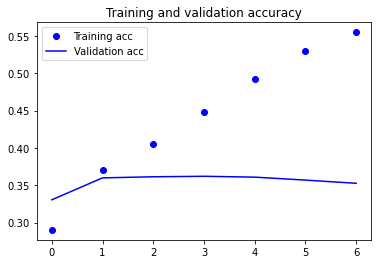

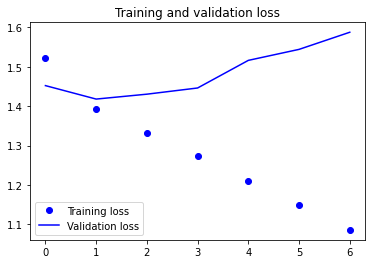

In [45]:
# Base Model (LSTM) (reran by accident)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 10s 48ms/step - loss: 1.5454 - acc: 0.2762 - val_loss: 1.4581 - val_acc: 0.3426
Epoch 2/100
190/190 [==============================] - 9s 47ms/step - loss: 1.3567 - acc: 0.4097 - val_loss: 1.4567 - val_acc: 0.3407
Epoch 3/100
190/190 [==============================] - 9s 46ms/step - loss: 1.1512 - acc: 0.5292 - val_loss: 1.6023 - val_acc: 0.3284
Epoch 4/100
190/190 [==============================] - 9s 46ms/step - loss: 0.9293 - acc: 0.6231 - val_loss: 1.7743 - val_acc: 0.3307
Epoch 5/100
190/190 [==============================] - 9s 46ms/step - loss: 0.8170 - acc: 0.6657 - val_loss: 1.9422 - val_acc: 0.3182
Epoch 6/100
190/190 [==============================] - 9s 46ms/step - loss: 0.7443 - acc: 0.6867 - val_loss: 2.1476 - val_acc: 0.3177
Epoch 7/100
190/190 [==============================] - 9s 46ms/step - loss: 0.7182 - acc: 0.6956 - val_loss: 2.2461 - val_acc: 0.3045


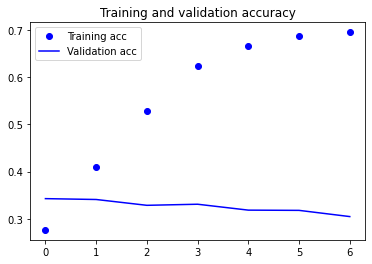

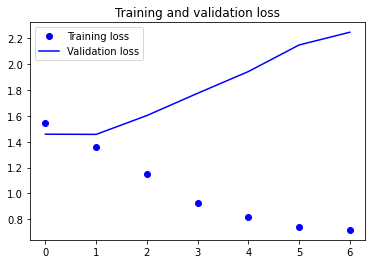

In [34]:
# Base Model (Simple RNN)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 32s 152ms/step - loss: 1.4982 - acc: 0.3079 - val_loss: 1.4371 - val_acc: 0.3427
Epoch 2/100
190/190 [==============================] - 28s 148ms/step - loss: 1.3730 - acc: 0.3850 - val_loss: 1.4207 - val_acc: 0.3543
Epoch 3/100
190/190 [==============================] - 28s 147ms/step - loss: 1.3064 - acc: 0.4292 - val_loss: 1.4209 - val_acc: 0.3783
Epoch 4/100
190/190 [==============================] - 28s 147ms/step - loss: 1.2361 - acc: 0.4764 - val_loss: 1.4713 - val_acc: 0.3571
Epoch 5/100
190/190 [==============================] - 28s 146ms/step - loss: 1.1586 - acc: 0.5240 - val_loss: 1.5169 - val_acc: 0.3569
Epoch 6/100
190/190 [==============================] - 28s 147ms/step - loss: 1.0866 - acc: 0.5543 - val_loss: 1.5782 - val_acc: 0.3546
Epoch 7/100
190/190 [==============================] - 28s 145ms/step - loss: 1.0260 - acc: 0.5770 - val_loss: 1.6677 - val_acc: 0.3531


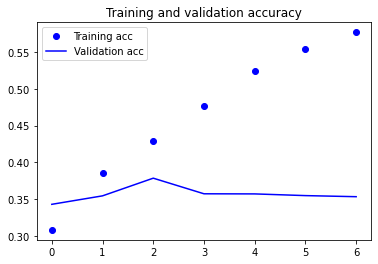

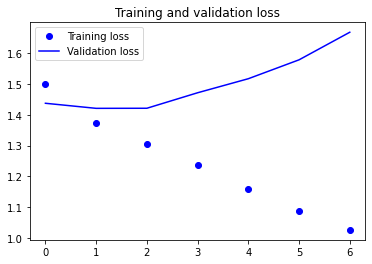

In [32]:
# Base Model (GRU)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) 
model.add(GRU(64, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)
                      
# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 44s 210ms/step - loss: 1.4938 - acc: 0.3138 - val_loss: 1.4246 - val_acc: 0.3582
Epoch 2/100
190/190 [==============================] - 39s 207ms/step - loss: 1.3701 - acc: 0.3876 - val_loss: 1.4203 - val_acc: 0.3668
Epoch 3/100
190/190 [==============================] - 40s 213ms/step - loss: 1.3015 - acc: 0.4288 - val_loss: 1.4286 - val_acc: 0.3668
Epoch 4/100
190/190 [==============================] - 39s 205ms/step - loss: 1.2357 - acc: 0.4749 - val_loss: 1.4830 - val_acc: 0.3699
Epoch 5/100
190/190 [==============================] - 38s 202ms/step - loss: 1.1643 - acc: 0.5161 - val_loss: 1.5207 - val_acc: 0.3671
Epoch 6/100
190/190 [==============================] - 39s 207ms/step - loss: 1.0959 - acc: 0.5507 - val_loss: 1.5732 - val_acc: 0.3501
Epoch 7/100
190/190 [==============================] - 43s 224ms/step - loss: 1.0432 - acc: 0.5724 - val_loss: 1.6145 - val_acc: 0.3637


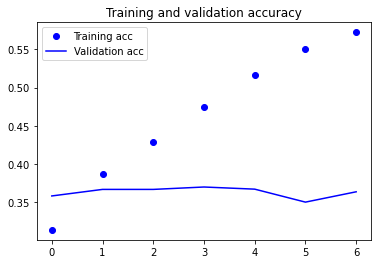

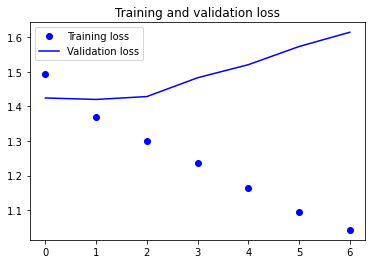

In [39]:
# GRU +1 GRU layer

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Default Adam lr
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 44s 216ms/step - loss: 1.4941 - acc: 0.3155 - val_loss: 1.4177 - val_acc: 0.3561
Epoch 2/100
190/190 [==============================] - 38s 202ms/step - loss: 1.3571 - acc: 0.3921 - val_loss: 1.4131 - val_acc: 0.3582
Epoch 3/100
190/190 [==============================] - 39s 203ms/step - loss: 1.2774 - acc: 0.4556 - val_loss: 1.4535 - val_acc: 0.3605
Epoch 4/100
190/190 [==============================] - 39s 203ms/step - loss: 1.1873 - acc: 0.5096 - val_loss: 1.5060 - val_acc: 0.3627
Epoch 5/100
190/190 [==============================] - 40s 210ms/step - loss: 1.1023 - acc: 0.5461 - val_loss: 1.5761 - val_acc: 0.3515
Epoch 6/100
190/190 [==============================] - 40s 209ms/step - loss: 1.0325 - acc: 0.5737 - val_loss: 1.6388 - val_acc: 0.3533
Epoch 7/100
190/190 [==============================] - 38s 202ms/step - loss: 0.9769 - acc: 0.5936 - val_loss: 1.6874 - val_acc: 0.3485


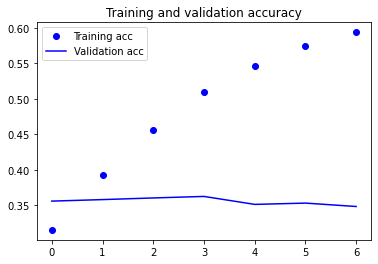

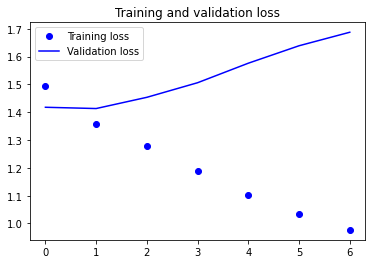

In [77]:
# GRU -1 GRU layer

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(
                          learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 21s 89ms/step - loss: 1.4966 - acc: 0.3083 - val_loss: 1.4242 - val_acc: 0.3526
Epoch 2/100
190/190 [==============================] - 16s 85ms/step - loss: 1.3705 - acc: 0.3884 - val_loss: 1.4061 - val_acc: 0.3701
Epoch 3/100
190/190 [==============================] - 17s 87ms/step - loss: 1.2940 - acc: 0.4384 - val_loss: 1.4374 - val_acc: 0.3605
Epoch 4/100
190/190 [==============================] - 16s 87ms/step - loss: 1.2243 - acc: 0.4909 - val_loss: 1.4763 - val_acc: 0.3697
Epoch 5/100
190/190 [==============================] - 16s 87ms/step - loss: 1.1458 - acc: 0.5293 - val_loss: 1.5367 - val_acc: 0.3607
Epoch 6/100
190/190 [==============================] - 17s 87ms/step - loss: 1.0771 - acc: 0.5577 - val_loss: 1.6099 - val_acc: 0.3609
Epoch 7/100
190/190 [==============================] - 17s 89ms/step - loss: 1.0240 - acc: 0.5802 - val_loss: 1.6561 - val_acc: 0.3539


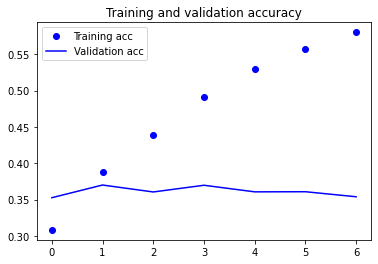

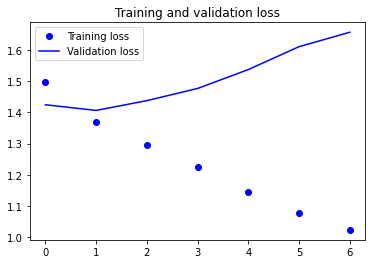

In [51]:
# GRU 32 Nodes (Selected)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 88s 448ms/step - loss: 1.4861 - acc: 0.3159 - val_loss: 1.4119 - val_acc: 0.3640
Epoch 2/100
190/190 [==============================] - 89s 468ms/step - loss: 1.3604 - acc: 0.3930 - val_loss: 1.4357 - val_acc: 0.3511
Epoch 3/100
190/190 [==============================] - 90s 476ms/step - loss: 1.2850 - acc: 0.4434 - val_loss: 1.4402 - val_acc: 0.3609
Epoch 4/100
190/190 [==============================] - 94s 496ms/step - loss: 1.1958 - acc: 0.5027 - val_loss: 1.4883 - val_acc: 0.3599
Epoch 5/100
190/190 [==============================] - 93s 487ms/step - loss: 1.1087 - acc: 0.5430 - val_loss: 1.5775 - val_acc: 0.3562
Epoch 6/100
190/190 [==============================] - 90s 474ms/step - loss: 1.0439 - acc: 0.5641 - val_loss: 1.6888 - val_acc: 0.3495


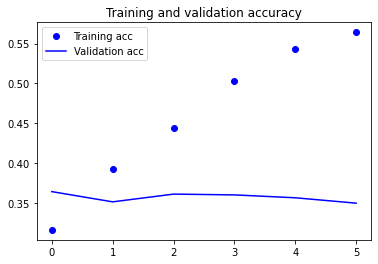

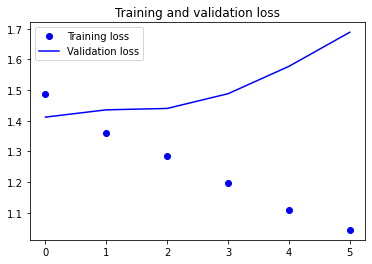

In [47]:
# GRU 128 Neurons

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(128, return_sequences=True))
model.add(GRU(128, return_sequences=True))
model.add(GRU(128))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 22s 95ms/step - loss: 1.4975 - acc: 0.3041 - val_loss: 1.4309 - val_acc: 0.3566
Epoch 2/100
190/190 [==============================] - 16s 86ms/step - loss: 1.3673 - acc: 0.3900 - val_loss: 1.4084 - val_acc: 0.3612
Epoch 3/100
190/190 [==============================] - 17s 89ms/step - loss: 1.2914 - acc: 0.4449 - val_loss: 1.4390 - val_acc: 0.3623
Epoch 4/100
190/190 [==============================] - 18s 95ms/step - loss: 1.2168 - acc: 0.4883 - val_loss: 1.4655 - val_acc: 0.3665
Epoch 5/100
190/190 [==============================] - 17s 90ms/step - loss: 1.1336 - acc: 0.5318 - val_loss: 1.5458 - val_acc: 0.3600
Epoch 6/100
190/190 [==============================] - 18s 92ms/step - loss: 1.0662 - acc: 0.5606 - val_loss: 1.5942 - val_acc: 0.3551
Epoch 7/100
190/190 [==============================] - 17s 88ms/step - loss: 1.0197 - acc: 0.5800 - val_loss: 1.7155 - val_acc: 0.3549


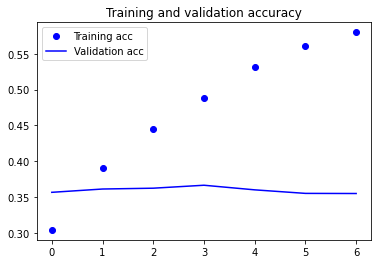

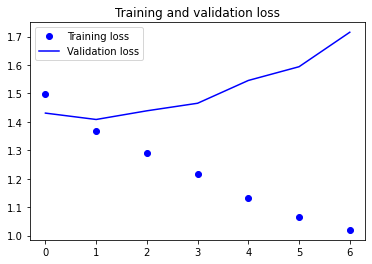

In [45]:
# Dense +1 Dense Layer

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 21s 94ms/step - loss: 1.5159 - acc: 0.2988 - val_loss: 1.4390 - val_acc: 0.3460
Epoch 2/100
190/190 [==============================] - 17s 91ms/step - loss: 1.3762 - acc: 0.3904 - val_loss: 1.4202 - val_acc: 0.3651
Epoch 3/100
190/190 [==============================] - 17s 92ms/step - loss: 1.2852 - acc: 0.4518 - val_loss: 1.4440 - val_acc: 0.3564
Epoch 4/100
190/190 [==============================] - 17s 91ms/step - loss: 1.1912 - acc: 0.5105 - val_loss: 1.4955 - val_acc: 0.3569
Epoch 5/100
190/190 [==============================] - 17s 91ms/step - loss: 1.1025 - acc: 0.5478 - val_loss: 1.5634 - val_acc: 0.3577
Epoch 6/100
190/190 [==============================] - 17s 91ms/step - loss: 1.0296 - acc: 0.5738 - val_loss: 1.6276 - val_acc: 0.3518
Epoch 7/100
190/190 [==============================] - 17s 91ms/step - loss: 0.9745 - acc: 0.5976 - val_loss: 1.6751 - val_acc: 0.3459


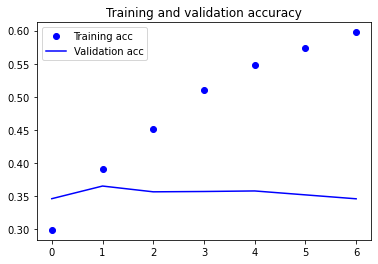

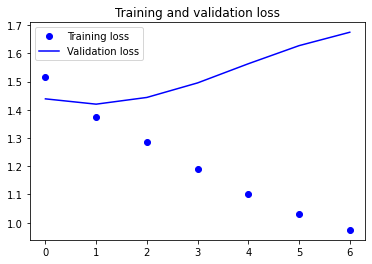

In [46]:
# Dense -1 Dense Layer

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 21s 93ms/step - loss: 1.5002 - acc: 0.3124 - val_loss: 1.4292 - val_acc: 0.3548
Epoch 2/100
190/190 [==============================] - 16s 86ms/step - loss: 1.3730 - acc: 0.3888 - val_loss: 1.4106 - val_acc: 0.3607
Epoch 3/100
190/190 [==============================] - 16s 85ms/step - loss: 1.2947 - acc: 0.4413 - val_loss: 1.4287 - val_acc: 0.3665
Epoch 4/100
190/190 [==============================] - 16s 86ms/step - loss: 1.2207 - acc: 0.4916 - val_loss: 1.4762 - val_acc: 0.3567
Epoch 5/100
190/190 [==============================] - 16s 86ms/step - loss: 1.1481 - acc: 0.5274 - val_loss: 1.5218 - val_acc: 0.3641
Epoch 6/100
190/190 [==============================] - 17s 90ms/step - loss: 1.0852 - acc: 0.5574 - val_loss: 1.5837 - val_acc: 0.3533
Epoch 7/100
190/190 [==============================] - 17s 88ms/step - loss: 1.0351 - acc: 0.5758 - val_loss: 1.6624 - val_acc: 0.3450


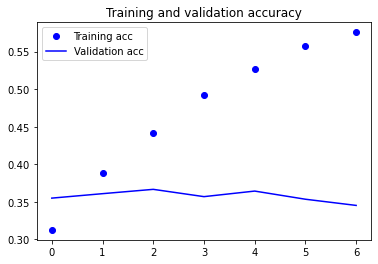

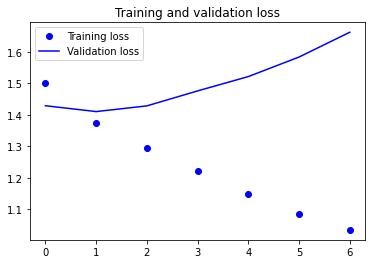

In [32]:
# Dense 32 Neurons

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(32, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 22s 94ms/step - loss: 1.4993 - acc: 0.3094 - val_loss: 1.4287 - val_acc: 0.3492
Epoch 2/100
190/190 [==============================] - 19s 102ms/step - loss: 1.3659 - acc: 0.3877 - val_loss: 1.4337 - val_acc: 0.3462
Epoch 3/100
190/190 [==============================] - 20s 106ms/step - loss: 1.2914 - acc: 0.4409 - val_loss: 1.4436 - val_acc: 0.3681
Epoch 4/100
190/190 [==============================] - 19s 99ms/step - loss: 1.2178 - acc: 0.4914 - val_loss: 1.4862 - val_acc: 0.3633
Epoch 5/100
190/190 [==============================] - 18s 93ms/step - loss: 1.1421 - acc: 0.5302 - val_loss: 1.5350 - val_acc: 0.3528
Epoch 6/100
190/190 [==============================] - 17s 89ms/step - loss: 1.0781 - acc: 0.5553 - val_loss: 1.6027 - val_acc: 0.3478


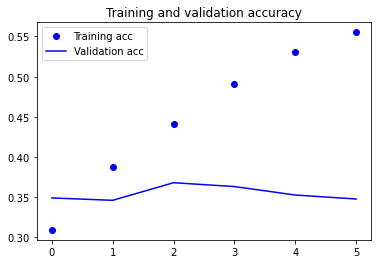

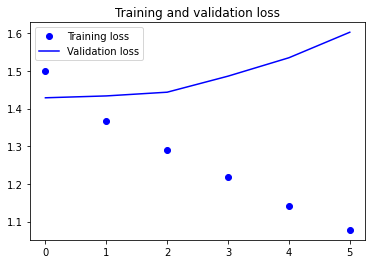

In [33]:
# Dense 128 Neurons

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(128, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 19s 86ms/step - loss: 1.5962 - acc: 0.2459 - val_loss: 1.5814 - val_acc: 0.2470
Epoch 2/100
190/190 [==============================] - 16s 82ms/step - loss: 1.5771 - acc: 0.2585 - val_loss: 1.5736 - val_acc: 0.2580
Epoch 3/100
190/190 [==============================] - 15s 82ms/step - loss: 1.5688 - acc: 0.2669 - val_loss: 1.5605 - val_acc: 0.2602
Epoch 4/100
190/190 [==============================] - 16s 82ms/step - loss: 1.5566 - acc: 0.2734 - val_loss: 1.5446 - val_acc: 0.2717
Epoch 5/100
190/190 [==============================] - 16s 82ms/step - loss: 1.5391 - acc: 0.2810 - val_loss: 1.5359 - val_acc: 0.2719
Epoch 6/100
190/190 [==============================] - 16s 82ms/step - loss: 1.5163 - acc: 0.2963 - val_loss: 1.5101 - val_acc: 0.2860
Epoch 7/100
190/190 [==============================] - 16s 82ms/step - loss: 1.4935 - acc: 0.3126 - val_loss: 1.4876 - val_acc: 0.3063
Epoch 8/100
190/190 [==============================] - 

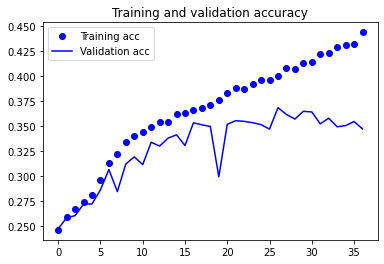

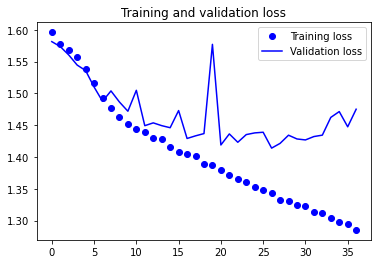

In [54]:
# SGD 0.1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=10),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 18s 76ms/step - loss: 1.5966 - acc: 0.2491 - val_loss: 1.5859 - val_acc: 0.2483
Epoch 2/100
190/190 [==============================] - 14s 74ms/step - loss: 1.5803 - acc: 0.2584 - val_loss: 1.5768 - val_acc: 0.2516
Epoch 3/100
190/190 [==============================] - 14s 73ms/step - loss: 1.5741 - acc: 0.2639 - val_loss: 1.5708 - val_acc: 0.2561
Epoch 4/100
190/190 [==============================] - 14s 73ms/step - loss: 1.5656 - acc: 0.2701 - val_loss: 1.5584 - val_acc: 0.2613
Epoch 5/100
190/190 [==============================] - 14s 75ms/step - loss: 1.5534 - acc: 0.2757 - val_loss: 1.5373 - val_acc: 0.2814
Epoch 6/100
190/190 [==============================] - 14s 75ms/step - loss: 1.5332 - acc: 0.2863 - val_loss: 1.5215 - val_acc: 0.2864
Epoch 7/100
190/190 [==============================] - 14s 74ms/step - loss: 1.5191 - acc: 0.2931 - val_loss: 1.5033 - val_acc: 0.3047
Epoch 8/100
190/190 [==============================] - 

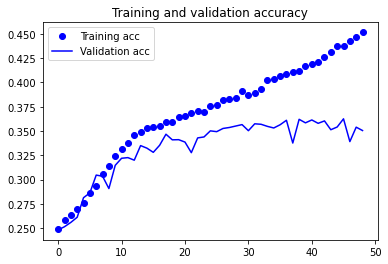

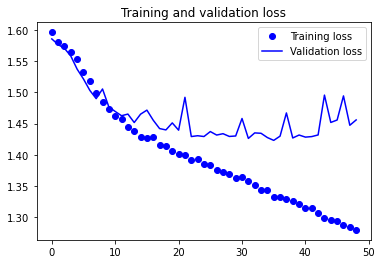

In [33]:
# SGD 0.07

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.07),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=13),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 19s 84ms/step - loss: 1.4610 - acc: 0.3305 - val_loss: 1.4098 - val_acc: 0.3638
Epoch 2/100
190/190 [==============================] - 15s 79ms/step - loss: 1.3379 - acc: 0.4114 - val_loss: 1.4099 - val_acc: 0.3730
Epoch 3/100
190/190 [==============================] - 15s 79ms/step - loss: 1.2342 - acc: 0.4818 - val_loss: 1.4672 - val_acc: 0.3651
Epoch 4/100
190/190 [==============================] - 15s 79ms/step - loss: 1.1350 - acc: 0.5299 - val_loss: 1.5373 - val_acc: 0.3544
Epoch 5/100
190/190 [==============================] - 15s 79ms/step - loss: 1.0418 - acc: 0.5662 - val_loss: 1.6506 - val_acc: 0.3534
Epoch 6/100
190/190 [==============================] - 15s 80ms/step - loss: 0.9642 - acc: 0.6032 - val_loss: 1.7271 - val_acc: 0.3449
Epoch 7/100
190/190 [==============================] - 15s 79ms/step - loss: 0.9029 - acc: 0.6249 - val_loss: 1.8397 - val_acc: 0.3467
Epoch 8/100
190/190 [==============================] - 

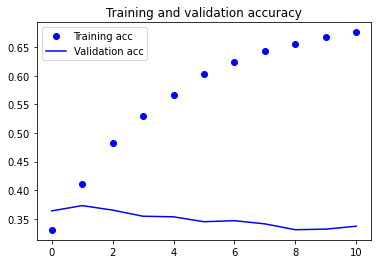

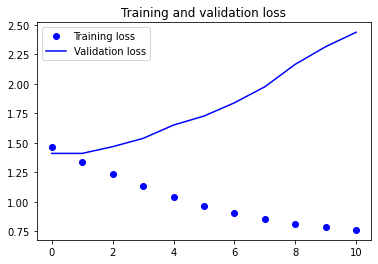

In [34]:
# Adam 0.003

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=10),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 19s 86ms/step - loss: 1.5126 - acc: 0.2991 - val_loss: 1.4500 - val_acc: 0.3358
Epoch 2/100
190/190 [==============================] - 16s 82ms/step - loss: 1.3923 - acc: 0.3741 - val_loss: 1.4292 - val_acc: 0.3587
Epoch 3/100
190/190 [==============================] - 16s 82ms/step - loss: 1.3266 - acc: 0.4116 - val_loss: 1.4252 - val_acc: 0.3707
Epoch 4/100
190/190 [==============================] - 16s 82ms/step - loss: 1.2655 - acc: 0.4545 - val_loss: 1.4717 - val_acc: 0.3554
Epoch 5/100
190/190 [==============================] - 16s 82ms/step - loss: 1.2051 - acc: 0.4977 - val_loss: 1.5031 - val_acc: 0.3468
Epoch 6/100
190/190 [==============================] - 16s 82ms/step - loss: 1.1423 - acc: 0.5316 - val_loss: 1.5771 - val_acc: 0.3496
Epoch 7/100
190/190 [==============================] - 16s 82ms/step - loss: 1.0862 - acc: 0.5576 - val_loss: 1.6006 - val_acc: 0.3503
Epoch 8/100
190/190 [==============================] - 

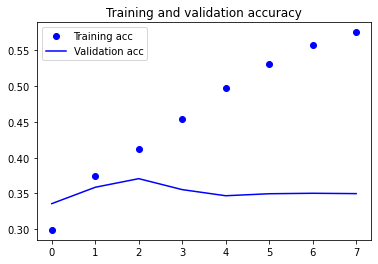

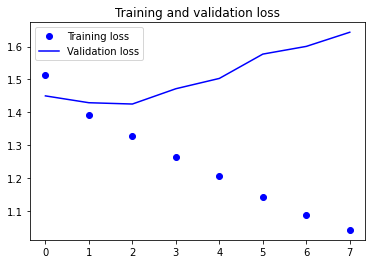

In [36]:
# Adam 0.0008 (Selected)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 20s 90ms/step - loss: 1.4943 - acc: 0.3157 - val_loss: 1.4262 - val_acc: 0.3506
Epoch 2/100
190/190 [==============================] - 17s 88ms/step - loss: 1.3657 - acc: 0.3921 - val_loss: 1.4190 - val_acc: 0.3622
Epoch 3/100
190/190 [==============================] - 17s 88ms/step - loss: 1.2947 - acc: 0.4384 - val_loss: 1.4370 - val_acc: 0.3580
Epoch 4/100
190/190 [==============================] - 17s 92ms/step - loss: 1.2252 - acc: 0.4888 - val_loss: 1.4795 - val_acc: 0.3539
Epoch 5/100
190/190 [==============================] - 17s 89ms/step - loss: 1.1560 - acc: 0.5258 - val_loss: 1.5273 - val_acc: 0.3569
Epoch 6/100
190/190 [==============================] - 17s 92ms/step - loss: 1.0942 - acc: 0.5518 - val_loss: 1.5930 - val_acc: 0.3587
Epoch 7/100
190/190 [==============================] - 18s 93ms/step - loss: 1.0392 - acc: 0.5756 - val_loss: 1.6439 - val_acc: 0.3439


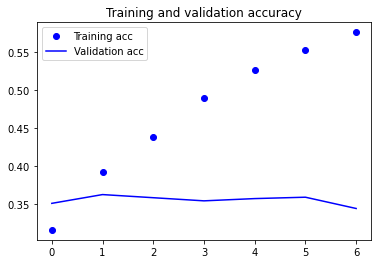

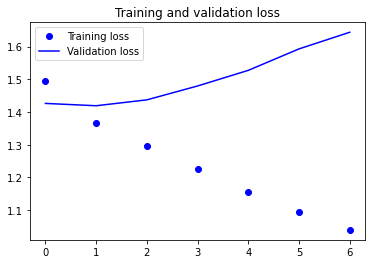

In [44]:
# Weight Initialization
glorot_init = tf.keras.initializers.GlorotUniform()
he_init = tf.keras.initializers.HeUniform()

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True, kernel_initializer=glorot_init, 
recurrent_initializer=glorot_init))
model.add(GRU(32, return_sequences=True, kernel_initializer=glorot_init,
recurrent_initializer=glorot_init))
model.add(GRU(32, kernel_initializer=glorot_init, recurrent_initializer=glorot_init))
model.add(Dense(64, activation="relu", kernel_initializer=he_init))
model.add(Dense(5, activation='softmax', kernel_initializer=glorot_init))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 21s 96ms/step - loss: 1.5040 - acc: 0.3132 - val_loss: 1.4327 - val_acc: 0.3473
Epoch 2/100
190/190 [==============================] - 17s 91ms/step - loss: 1.3730 - acc: 0.3903 - val_loss: 1.4184 - val_acc: 0.3618
Epoch 3/100
190/190 [==============================] - 17s 91ms/step - loss: 1.2965 - acc: 0.4410 - val_loss: 1.4358 - val_acc: 0.3609
Epoch 4/100
190/190 [==============================] - 17s 91ms/step - loss: 1.2264 - acc: 0.4883 - val_loss: 1.4821 - val_acc: 0.3618
Epoch 5/100
190/190 [==============================] - 17s 92ms/step - loss: 1.1533 - acc: 0.5265 - val_loss: 1.5206 - val_acc: 0.3589
Epoch 6/100
190/190 [==============================] - 17s 91ms/step - loss: 1.0901 - acc: 0.5517 - val_loss: 1.6117 - val_acc: 0.3549
Epoch 7/100
190/190 [==============================] - 17s 91ms/step - loss: 1.0415 - acc: 0.5711 - val_loss: 1.6449 - val_acc: 0.3534


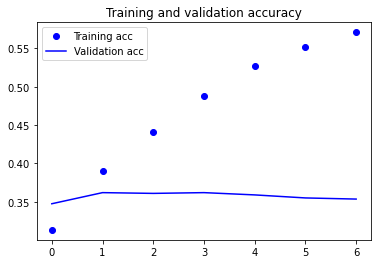

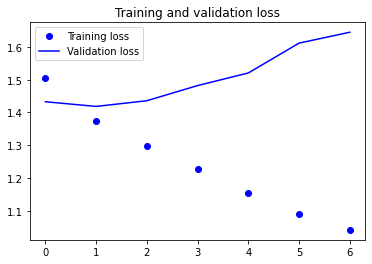

In [45]:
# Weight Initialization (recurrent back to default initializer)
glorot_init = tf.keras.initializers.GlorotUniform()
he_init = tf.keras.initializers.HeUniform()

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True, kernel_initializer=glorot_init))
model.add(GRU(32, return_sequences=True, kernel_initializer=glorot_init))
model.add(GRU(32, kernel_initializer=glorot_init))
model.add(Dense(64, activation="relu", kernel_initializer=he_init))
model.add(Dense(5, activation='softmax', kernel_initializer=glorot_init))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 22s 101ms/step - loss: 1.4988 - acc: 0.3096 - val_loss: 1.4330 - val_acc: 0.3544
Epoch 2/100
190/190 [==============================] - 18s 94ms/step - loss: 1.3691 - acc: 0.3857 - val_loss: 1.4183 - val_acc: 0.3622
Epoch 3/100
190/190 [==============================] - 18s 92ms/step - loss: 1.3010 - acc: 0.4335 - val_loss: 1.4402 - val_acc: 0.3613
Epoch 4/100
190/190 [==============================] - 18s 96ms/step - loss: 1.2275 - acc: 0.4857 - val_loss: 1.4633 - val_acc: 0.3707
Epoch 5/100
190/190 [==============================] - 18s 96ms/step - loss: 1.1464 - acc: 0.5292 - val_loss: 1.5536 - val_acc: 0.3587
Epoch 6/100
190/190 [==============================] - 18s 96ms/step - loss: 1.0822 - acc: 0.5513 - val_loss: 1.6115 - val_acc: 0.3544
Epoch 7/100
190/190 [==============================] - 19s 98ms/step - loss: 1.0266 - acc: 0.5702 - val_loss: 1.6528 - val_acc: 0.3501


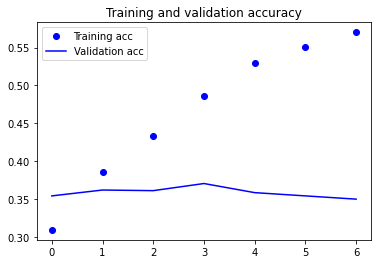

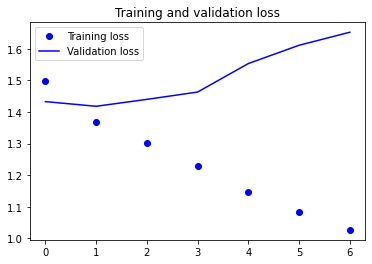

In [63]:
# tanh

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="tanh"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 29s 132ms/step - loss: 1.5273 - acc: 0.2844 - val_loss: 1.4674 - val_acc: 0.3197
Epoch 2/100
190/190 [==============================] - 25s 130ms/step - loss: 1.4252 - acc: 0.3497 - val_loss: 1.4352 - val_acc: 0.3496
Epoch 3/100
190/190 [==============================] - 25s 130ms/step - loss: 1.3637 - acc: 0.3927 - val_loss: 1.4248 - val_acc: 0.3590
Epoch 4/100
190/190 [==============================] - 24s 129ms/step - loss: 1.3138 - acc: 0.4217 - val_loss: 1.4442 - val_acc: 0.3580
Epoch 5/100
190/190 [==============================] - 25s 134ms/step - loss: 1.2531 - acc: 0.4624 - val_loss: 1.4941 - val_acc: 0.3574
Epoch 6/100
190/190 [==============================] - 25s 131ms/step - loss: 1.1948 - acc: 0.5028 - val_loss: 1.5452 - val_acc: 0.3480
Epoch 7/100
190/190 [==============================] - 25s 132ms/step - loss: 1.1392 - acc: 0.5333 - val_loss: 1.6130 - val_acc: 0.3437
Epoch 8/100
190/190 [===========================

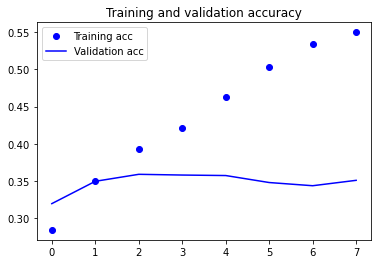

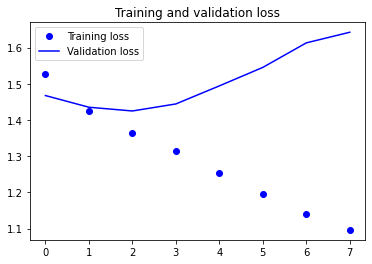

In [66]:
# Dropout 0.5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.5))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.5))
model.add(GRU(32, recurrent_dropout=0.5))
model.add(Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 29s 131ms/step - loss: 1.5668 - acc: 0.2680 - val_loss: 1.4864 - val_acc: 0.3129
Epoch 2/100
190/190 [==============================] - 25s 130ms/step - loss: 1.4591 - acc: 0.3406 - val_loss: 1.4314 - val_acc: 0.3513
Epoch 3/100
190/190 [==============================] - 25s 129ms/step - loss: 1.3873 - acc: 0.3934 - val_loss: 1.4284 - val_acc: 0.3623
Epoch 4/100
190/190 [==============================] - 24s 127ms/step - loss: 1.3305 - acc: 0.4345 - val_loss: 1.4389 - val_acc: 0.3559
Epoch 5/100
190/190 [==============================] - 24s 126ms/step - loss: 1.2751 - acc: 0.4694 - val_loss: 1.4958 - val_acc: 0.3538
Epoch 6/100
190/190 [==============================] - 24s 126ms/step - loss: 1.2250 - acc: 0.4929 - val_loss: 1.5274 - val_acc: 0.3496
Epoch 7/100
190/190 [==============================] - 24s 125ms/step - loss: 1.1851 - acc: 0.5156 - val_loss: 1.5789 - val_acc: 0.3462
Epoch 8/100
190/190 [===========================

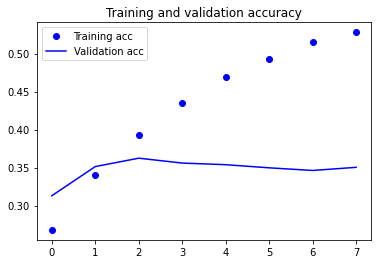

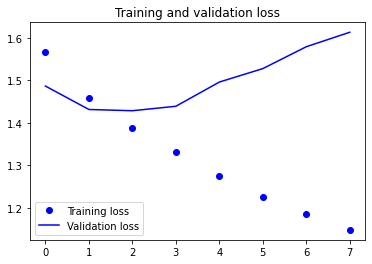

In [67]:
# Dropout 0.7

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.7))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.7))
model.add(GRU(32, recurrent_dropout=0.7))
model.add(Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.7))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 28s 130ms/step - loss: 1.5194 - acc: 0.2966 - val_loss: 1.4501 - val_acc: 0.3300
Epoch 2/100
190/190 [==============================] - 24s 127ms/step - loss: 1.4019 - acc: 0.3672 - val_loss: 1.4221 - val_acc: 0.3495
Epoch 3/100
190/190 [==============================] - 24s 128ms/step - loss: 1.3331 - acc: 0.4115 - val_loss: 1.4244 - val_acc: 0.3536
Epoch 4/100
190/190 [==============================] - 24s 125ms/step - loss: 1.2765 - acc: 0.4534 - val_loss: 1.4654 - val_acc: 0.3562
Epoch 5/100
190/190 [==============================] - 24s 128ms/step - loss: 1.2169 - acc: 0.4902 - val_loss: 1.4927 - val_acc: 0.3609
Epoch 6/100
190/190 [==============================] - 24s 128ms/step - loss: 1.1553 - acc: 0.5276 - val_loss: 1.5542 - val_acc: 0.3544
Epoch 7/100
190/190 [==============================] - 24s 125ms/step - loss: 1.1006 - acc: 0.5512 - val_loss: 1.6116 - val_acc: 0.3552


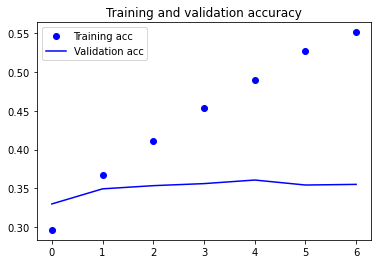

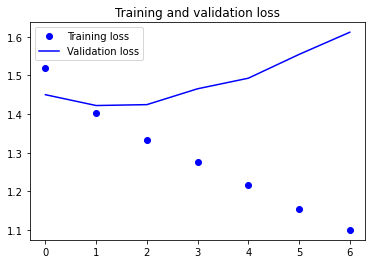

In [70]:
# Dropout 0.3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.2))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.2))
model.add(GRU(32, recurrent_dropout=0.2))
model.add(Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 20s 87ms/step - loss: 2.7998 - acc: 0.2461 - val_loss: 1.8725 - val_acc: 0.2628
Epoch 2/100
190/190 [==============================] - 16s 83ms/step - loss: 1.6438 - acc: 0.3007 - val_loss: 1.5456 - val_acc: 0.3099
Epoch 3/100
190/190 [==============================] - 16s 83ms/step - loss: 1.5006 - acc: 0.3324 - val_loss: 1.5245 - val_acc: 0.3137
Epoch 4/100
190/190 [==============================] - 16s 82ms/step - loss: 1.4644 - acc: 0.3444 - val_loss: 1.5256 - val_acc: 0.3131
Epoch 5/100
190/190 [==============================] - 15s 80ms/step - loss: 1.4415 - acc: 0.3605 - val_loss: 1.5222 - val_acc: 0.3211
Epoch 6/100
190/190 [==============================] - 15s 79ms/step - loss: 1.4212 - acc: 0.3731 - val_loss: 1.5289 - val_acc: 0.3152
Epoch 7/100
190/190 [==============================] - 15s 79ms/step - loss: 1.4026 - acc: 0.3769 - val_loss: 1.5433 - val_acc: 0.3159
Epoch 8/100
190/190 [==============================] - 

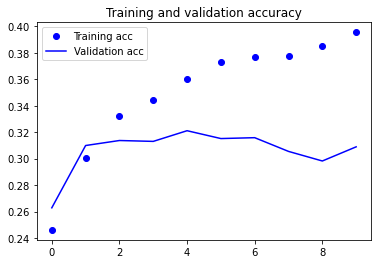

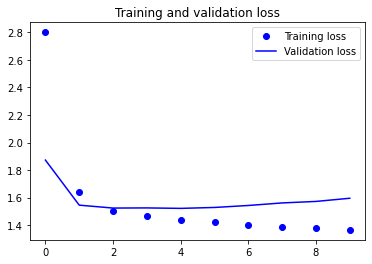

In [33]:
# L2 = 0.01 
reg = tf.keras.regularizers.L2(l2=0.01)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(GRU(32, return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(GRU(32, kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(Dense(64, activation="relu", kernel_regularizer=reg))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

Epoch 1/100
190/190 [==============================] - 19s 80ms/step - loss: 1.6744 - acc: 0.2953 - val_loss: 1.5457 - val_acc: 0.3144
Epoch 2/100
190/190 [==============================] - 15s 78ms/step - loss: 1.4872 - acc: 0.3328 - val_loss: 1.5046 - val_acc: 0.3223
Epoch 3/100
190/190 [==============================] - 15s 79ms/step - loss: 1.4311 - acc: 0.3565 - val_loss: 1.5004 - val_acc: 0.3259
Epoch 4/100
190/190 [==============================] - 15s 77ms/step - loss: 1.3942 - acc: 0.3775 - val_loss: 1.5119 - val_acc: 0.3262
Epoch 5/100
190/190 [==============================] - 15s 78ms/step - loss: 1.3655 - acc: 0.4006 - val_loss: 1.5327 - val_acc: 0.3093
Epoch 6/100
190/190 [==============================] - 15s 78ms/step - loss: 1.3369 - acc: 0.4230 - val_loss: 1.5540 - val_acc: 0.3073
Epoch 7/100
190/190 [==============================] - 15s 78ms/step - loss: 1.3076 - acc: 0.4419 - val_loss: 1.5708 - val_acc: 0.3098
Epoch 8/100
190/190 [==============================] - 

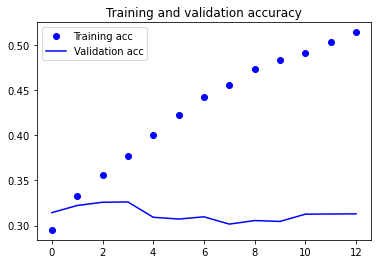

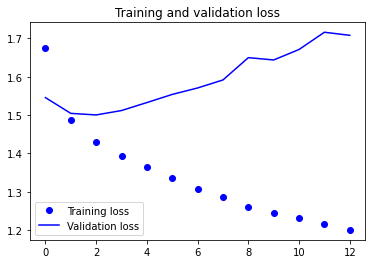

In [34]:
# L2 = 0.001
reg = tf.keras.regularizers.L2(l2=0.001)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True,
          kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(GRU(32, return_sequences=True,
          kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(GRU(32, kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(Dense(64, activation="relu", kernel_regularizer=reg))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=10),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 21s 87ms/step - loss: 2.3056 - acc: 0.2664 - val_loss: 1.7088 - val_acc: 0.2953
Epoch 2/100
190/190 [==============================] - 16s 82ms/step - loss: 1.5677 - acc: 0.3193 - val_loss: 1.5278 - val_acc: 0.3114
Epoch 3/100
190/190 [==============================] - 16s 82ms/step - loss: 1.4725 - acc: 0.3403 - val_loss: 1.5242 - val_acc: 0.3029
Epoch 4/100
190/190 [==============================] - 16s 82ms/step - loss: 1.4380 - acc: 0.3558 - val_loss: 1.5133 - val_acc: 0.3142
Epoch 5/100
190/190 [==============================] - 15s 80ms/step - loss: 1.4122 - acc: 0.3697 - val_loss: 1.5360 - val_acc: 0.3083
Epoch 6/100
190/190 [==============================] - 15s 79ms/step - loss: 1.3931 - acc: 0.3759 - val_loss: 1.5318 - val_acc: 0.3004
Epoch 7/100
190/190 [==============================] - 15s 79ms/step - loss: 1.3741 - acc: 0.3846 - val_loss: 1.5554 - val_acc: 0.3050
Epoch 8/100
190/190 [==============================] - 

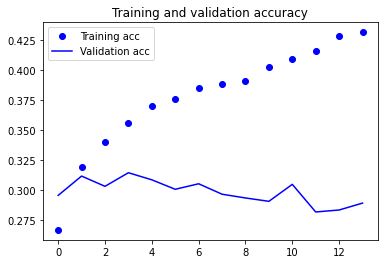

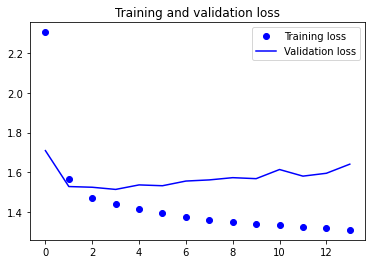

In [36]:
# L2 = 0.02
reg = tf.keras.regularizers.L2(l2=0.006)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True,
          kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(GRU(32, return_sequences=True,
          kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(GRU(32, kernel_regularizer=reg, recurrent_regularizer=reg))
model.add(Dense(64, activation="relu", kernel_regularizer=reg))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=10),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/100
190/190 [==============================] - 21s 86ms/step - loss: 1.5197 - acc: 0.2971 - val_loss: 1.4568 - val_acc: 0.3355
Epoch 2/100
190/190 [==============================] - 15s 79ms/step - loss: 1.3944 - acc: 0.3738 - val_loss: 1.4247 - val_acc: 0.3546
Epoch 3/100
190/190 [==============================] - 15s 81ms/step - loss: 1.3228 - acc: 0.4172 - val_loss: 1.4392 - val_acc: 0.3633
Epoch 4/100
190/190 [==============================] - 15s 81ms/step - loss: 1.2618 - acc: 0.4570 - val_loss: 1.4667 - val_acc: 0.3584
Epoch 5/100
190/190 [==============================] - 15s 81ms/step - loss: 1.1993 - acc: 0.5002 - val_loss: 1.5146 - val_acc: 0.3595
Epoch 6/100
190/190 [==============================] - 15s 81ms/step - loss: 1.1383 - acc: 0.5326 - val_loss: 1.5506 - val_acc: 0.3478
Epoch 7/100
190/190 [==============================] - 15s 81ms/step - loss: 1.0857 - acc: 0.5560 - val_loss: 1.6117 - val_acc: 0.3498


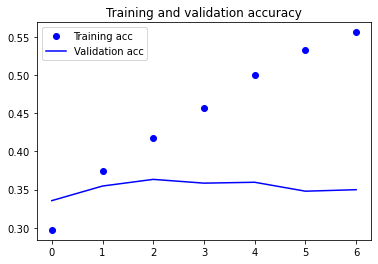

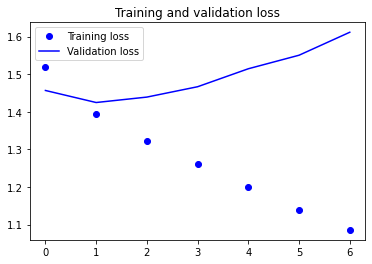

In [41]:
# Weight Initialization
import tensorflow_addons as tfa

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tfa.layers.WeightNormalization(GRU(32, return_sequences=True), data_init=False))
model.add(tfa.layers.WeightNormalization(GRU(32, return_sequences=True), data_init=False))
model.add(tfa.layers.WeightNormalization(GRU(32), data_init=False))
model.add(tfa.layers.WeightNormalization(Dense(64, activation="relu"), data_init=False))
model.add(tfa.layers.WeightNormalization(Dense(5, activation='softmax'), data_init=False))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=100,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)


Epoch 1/2
190/190 [==============================] - 21s 94ms/step - loss: 1.5088 - acc: 0.3050 - val_loss: 1.4424 - val_acc: 0.3406
Epoch 2/2
190/190 [==============================] - 17s 91ms/step - loss: 1.3807 - acc: 0.3837 - val_loss: 1.4128 - val_acc: 0.3617


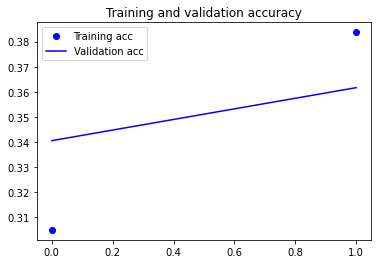

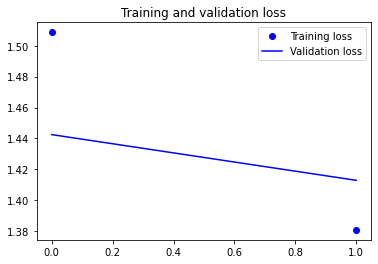

In [61]:
# Final Model Adam 0.0008 (Up to epoch 2, pre-overfitting)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

history = compile_fit(model=model,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'],
                      callback=tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss', patience=5),
                      batch_size=128,
                      epochs=2,
                      X_train=X_train,
                      y_train=y_train)

# Plot the Training and Validation Accuracy & Loss Scores
graphs(history)

In [63]:
model.save('best_model_Dominic.h5')

In [37]:
sentence = np.array(["This is a trash app but its good"])

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length,
                       padding=padding_type, truncating=trunc_type)

print(padded)
print(model.predict(padded))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  32  10   9 646   2 103   1   3]]
[[0.00339422 0.0091054  0.06197537 0.7904788  0.13504614]]


## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

In [ ]:
snapchat_dataset = df[["content_final", "score"]]
snapchat_dataset.to_csv("snapchat_dataset.csv", index=False)

In [81]:
def strings(text):
 text = str(text)
 return text

def evaluate(path):
 dataset = pd.read_csv(path)
 dataset['content_final'] = dataset['content_final'].apply(lambda x:strings(x))
 dataset_train_seqs = tokenizer.texts_to_sequences(dataset['content_final'])
 dataset_train_padded = pad_sequences(dataset_train_seqs, maxlen=max_length, truncating=trunc_type, padding=padding_type)
 X_dataset = dataset_train_padded
 y_dataset = dataset['score']
 X_train, X_test, y_train, y_test =  train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

 model = tf.keras.models.load_model("best_model_Dominic.h5")
 print("Testing for: " + path + " (snapchat model)")
 return model.evaluate(X_test, y_test)


In [82]:
snapchat_model = tf.keras.models.load_model("best_model_Dominic.h5")
print("Testing for: snapchat_dataset.csv (snapchat model)")
snapchat_model.evaluate(X_test, y_test)

Testing for: snapchat_dataset.csv (snapchat model)
238/238 [==============================] - 4s 12ms/step - loss: 1.4101 - acc: 0.3732


[1.4100924730300903, 0.37318745255470276]

In [83]:
evaluate("disney_dataset.csv")

Testing for: disney_dataset.csv (snapchat model)
243/243 [==============================] - 4s 12ms/step - loss: 1.7867 - acc: 0.3492


[1.78665292263031, 0.34924718737602234]

In [84]:
evaluate("insta_dataset.csv")

Testing for: insta_dataset.csv (snapchat model)
239/239 [==============================] - 4s 11ms/step - loss: 1.7353 - acc: 0.3191


[1.735291600227356, 0.3191155195236206]

In [85]:
evaluate("templerun_dataset.csv")

Testing for: templerun_dataset.csv (snapchat model)
238/238 [==============================] - 4s 11ms/step - loss: 1.9502 - acc: 0.2497


[1.9502053260803223, 0.24970367550849915]

In [86]:
evaluate("facebook_dataset.csv")

Testing for: facebook_dataset.csv (snapchat model)
250/250 [==============================] - 4s 12ms/step - loss: 1.9997 - acc: 0.2720


[1.9997477531433105, 0.2720000147819519]

In [ ]:
# Save the Best Model
model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction (Group)

In [ ]:
best_model = keras.models.load_model('text_model_best.h5')

In [ ]:
# takes the user input
text_input = np.array([input()])

In [ ]:
# convert the user input into numeric tensor


In [ ]:
# show the model output using predict function

